In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
from sqlalchemy.sql.expression import func
last_date = session.query(func.max(Measurement.date)).all()
last_date

[('2017-08-23',)]

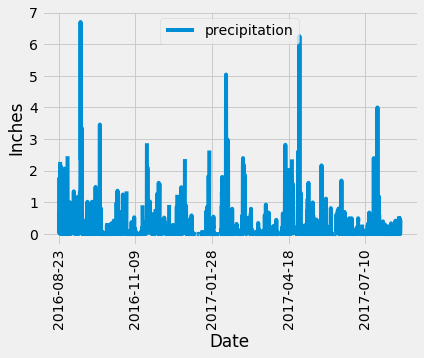

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns=['precipitation','date'])

# Sort the dataframe by date
precip_df=precip_df.sort_values(by=['date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='date', y='precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_sum=pd.DataFrame(precip_df['precipitation'].describe())
precip_sum

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(func.count(Station.station)).all()
stations_count

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_acive_station = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for row in most_acive_station:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_act_st_id=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]


most_act_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
               filter(Measurement.station == most_act_st_id).group_by(Measurement.station)

most_act_stats[0]

(54.0, 85.0, 71.66378066378067)

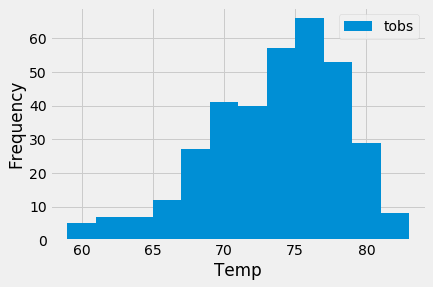

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_act_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
               filter(Measurement.station == most_act_st_id).group_by(Measurement.station)

most_act_stats[0]
yearago_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == most_act_st_id)
tobs_yearago_df = pd.DataFrame(yearago_tobs)
tobs_yearago_df.rename(columns={0:"Date",1:"tobs"},inplace=True) 
tobs_yearago_sorted = tobs_yearago_df.sort_values(by="Date")
tobs_yearago_sorted

tobs_yearago_sorted.plot.hist(bins=12)
plt.xlabel("Temp")
plt.ylabel("Frequency")
# plt.xticks(rotation=90)
plt.savefig("Date_tobs.png")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()